# Care restoration (prediction)

In this notebook we use the trained CARE network to restore an image

In [44]:
from skimage.io import imread, imsave
from tnia.plotting.projections import show_xyz_slice, show_xyz_max
from csbdeep.models import Config, CARE
from csbdeep.utils import normalize
from skimage.transform import resize
import sys
sys.path.append('../')
import decon_helper as dh
import os

# Load an input image

In this cell we load an input image.  Note that the image is bigger than the patch size we trained on.  The CSBDeep framework will take care of applying the network in chunks. 

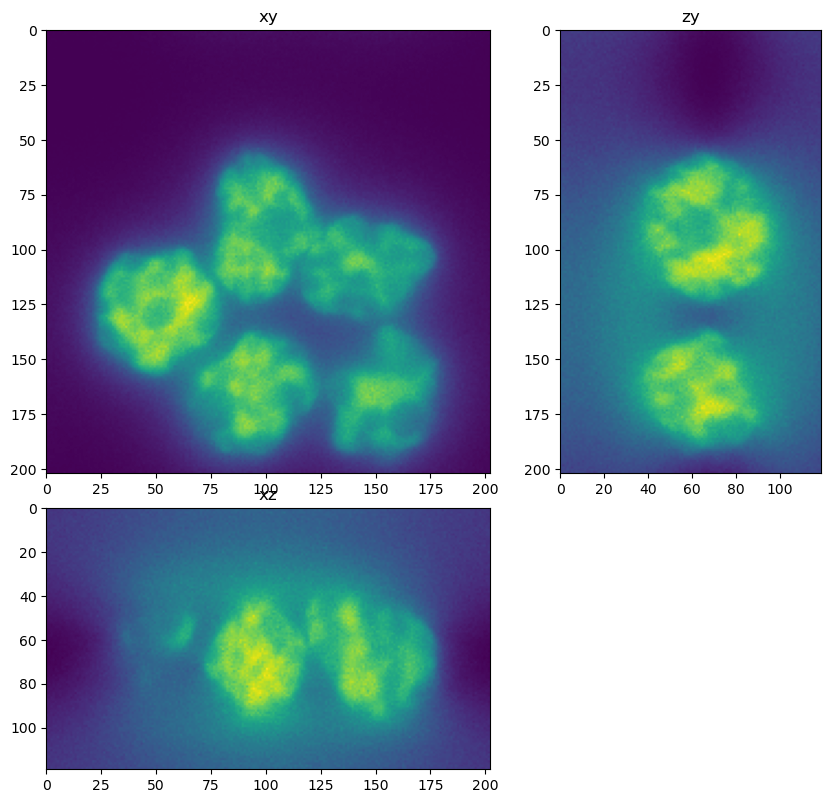

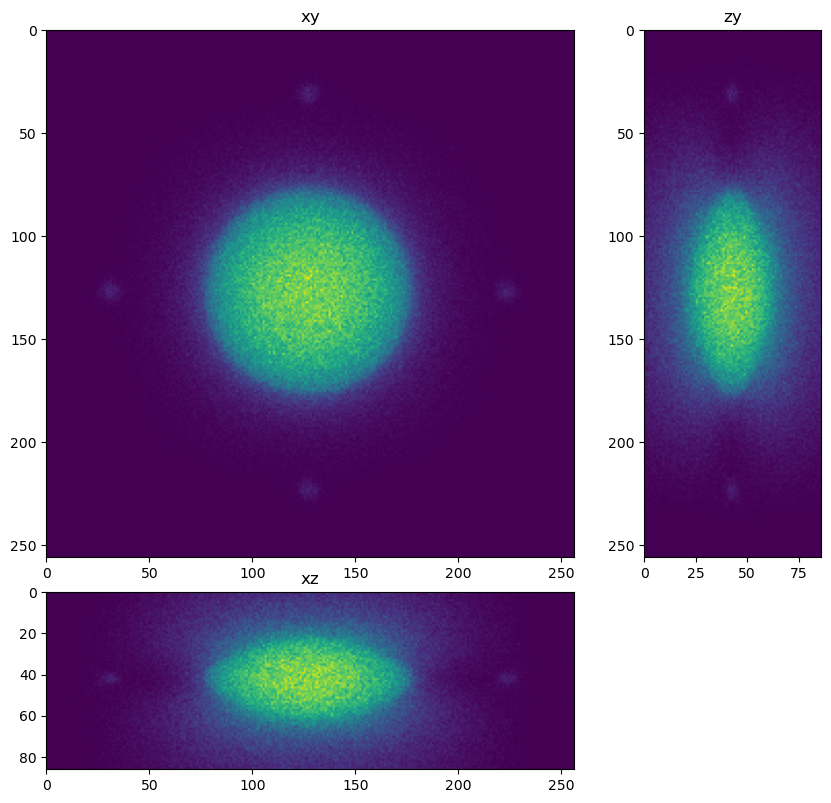

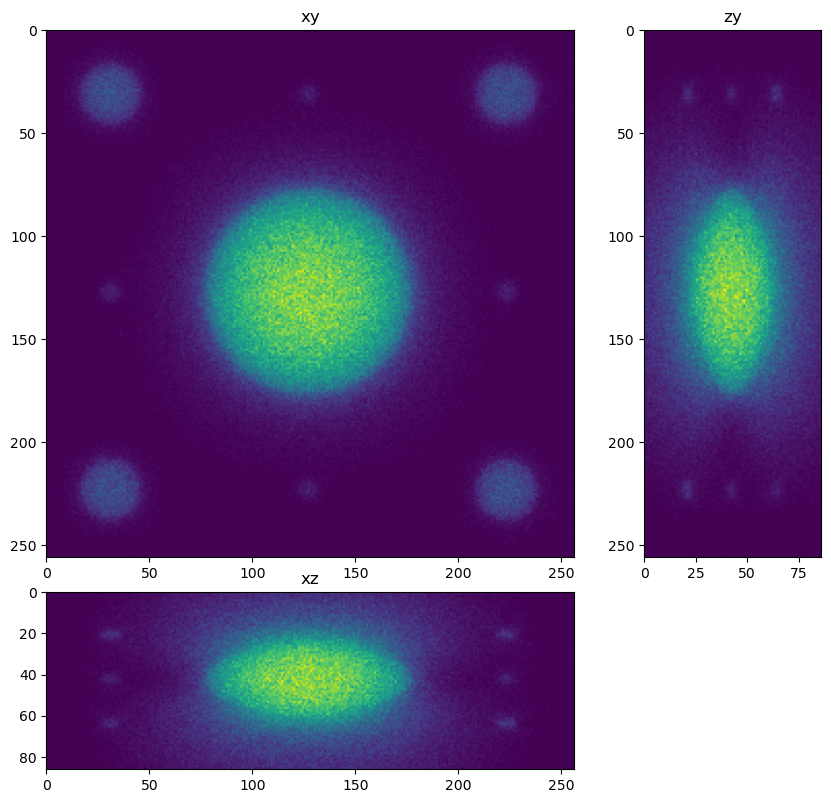

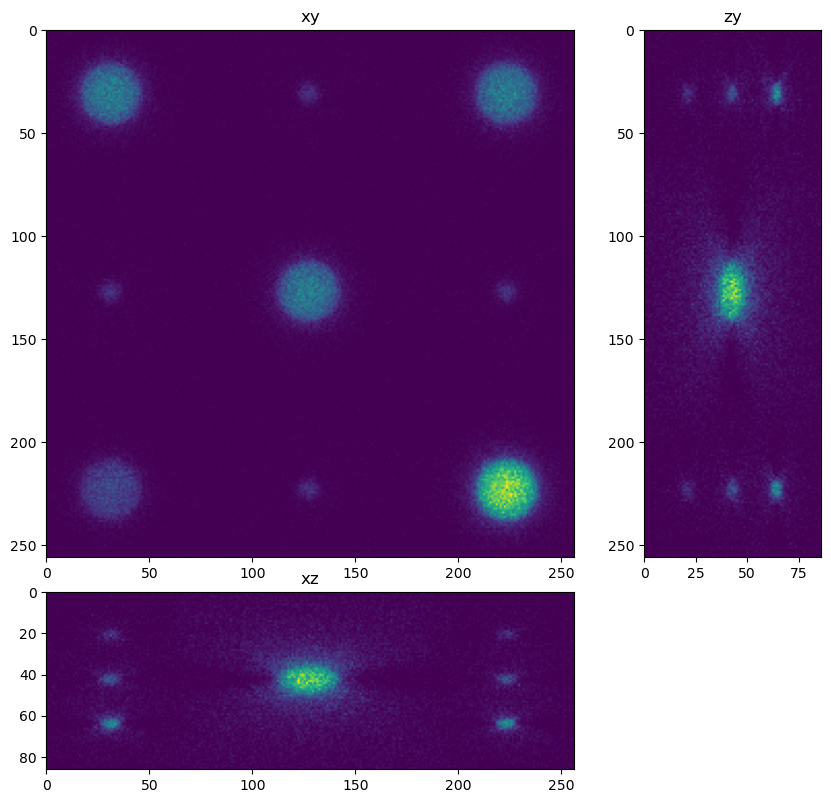

In [45]:
input_names = [r'../../data/deep learning testing/inputs/nuclei.tif',
              r'../../data/deep learning testing/inputs/spheres1.tif',
              r'../../data/deep learning testing/inputs/spheres2.tif',
              r'../../data/deep learning testing/inputs/spheres4.tif']
inputs=[]
minmaxes=[]

pmin = 0
pmax = 100

for input_name in input_names:
    input = imread(input_name)
    nmin=input.min()
    nmax=input.max()

    # put min and max in dictionary
    minmaxes.append({'min':nmin, 'max':nmax})
    input = normalize(input, pmin, pmax)

    #input = (input.astype('float32')-nmin) / (nmax - nmin)
    inputs.append(input)
    dh.show_xyz_slice(input, 'tnia')

# Load the model

Load the model that we trained in the previous notebook

In [51]:
# load the model using the name of the model and the path to the model

model_name = 'cytopacq'
#model_name = 'spheres'
#model_name = 'combined'
#model_name = 'spheres_improved'

model = CARE(None, model_name, basedir='../../models')

Loading network weights from 'weights_best.h5'.


# Apply the model

In [52]:
restorations = []

for input in inputs:
    restored = model.predict(input, axes='ZYX', n_tiles=(1, 2, 2), normalizer=None)
    restorations.append(restored)

1/1 [==============================] - 0s 261ms/step


 25%|██▌       | 1/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 2/4 [00:00<00:00,  6.05it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

1/1 [==============================] - 0s 46ms/step



 25%|██▌       | 1/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 2/4 [00:00<00:00,  5.93it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 3/4 [00:00<00:00,  4.09it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

1/1 [==============================] - 0s 46ms/step



 25%|██▌       | 1/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 2/4 [00:00<00:00,  5.92it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


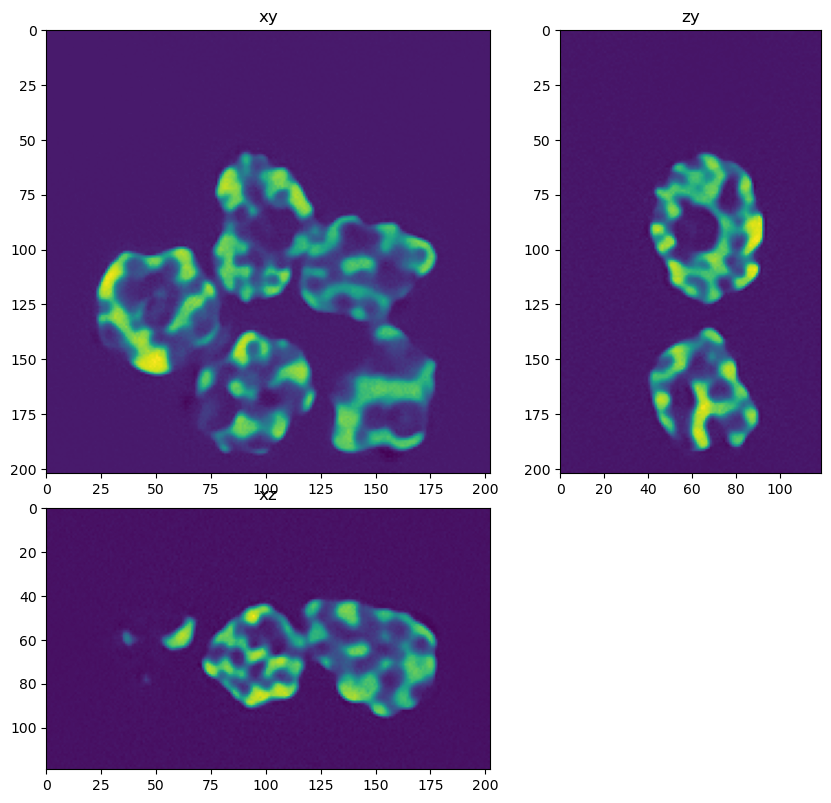

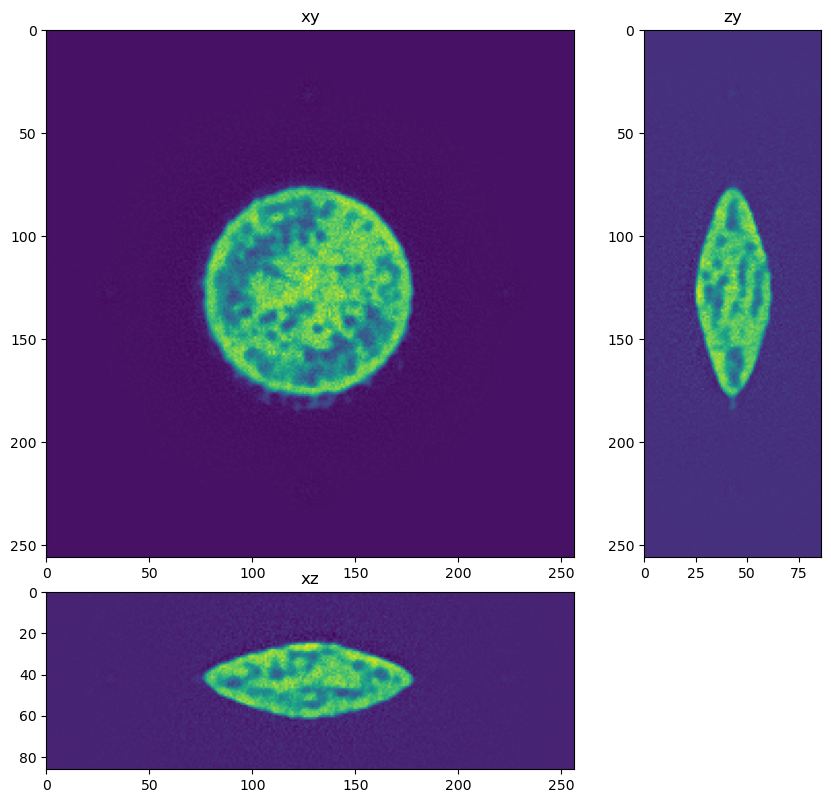

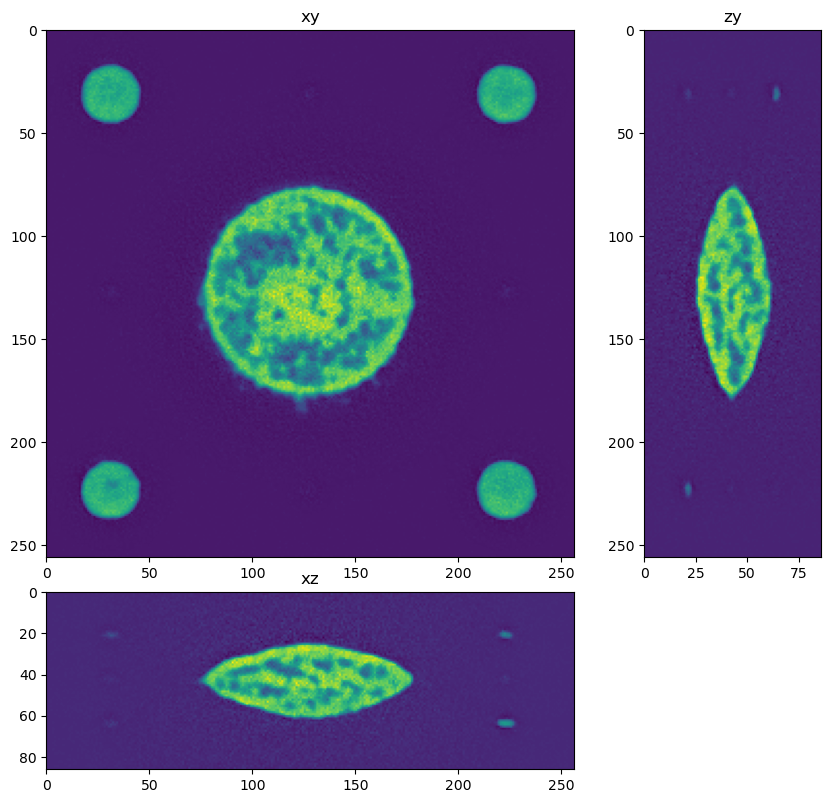

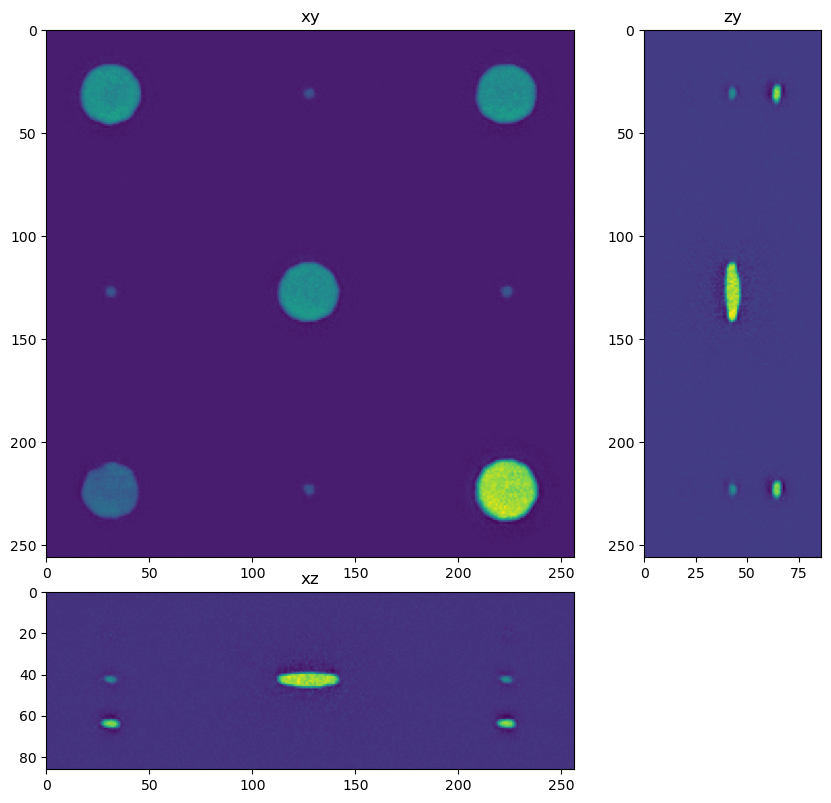

In [53]:
for restored in restorations:
    dh.show_xyz_slice(restored, 'tnia')

In [49]:
import napari
import numpy as np
n=3
decon = imread(r'../../data/deep learning testing/deconvolutions/spheres4.tif')
viewer = napari.Viewer()
viewer.add_image(inputs[n], name='input')
viewer.add_image(np.clip(restorations[n],0, restorations[n].max()), name='restored')
viewer.add_image(decon, name='deconvolution')

<Image layer 'deconvolution' at 0x2aed8cacf10>

In [50]:
print(inputs[n].min(), inputs[n].max(), inputs[n].mean())
print(restorations[n].min(), restorations[n].max(), restorations[n].mean())

0.0 1.0 0.012505261
-0.22564787 1.2641255 0.005944527


## Plot line profiles to see if relative intensities were preserved

This is tricky, because we have to 'denormalize' the output from the neural network.  

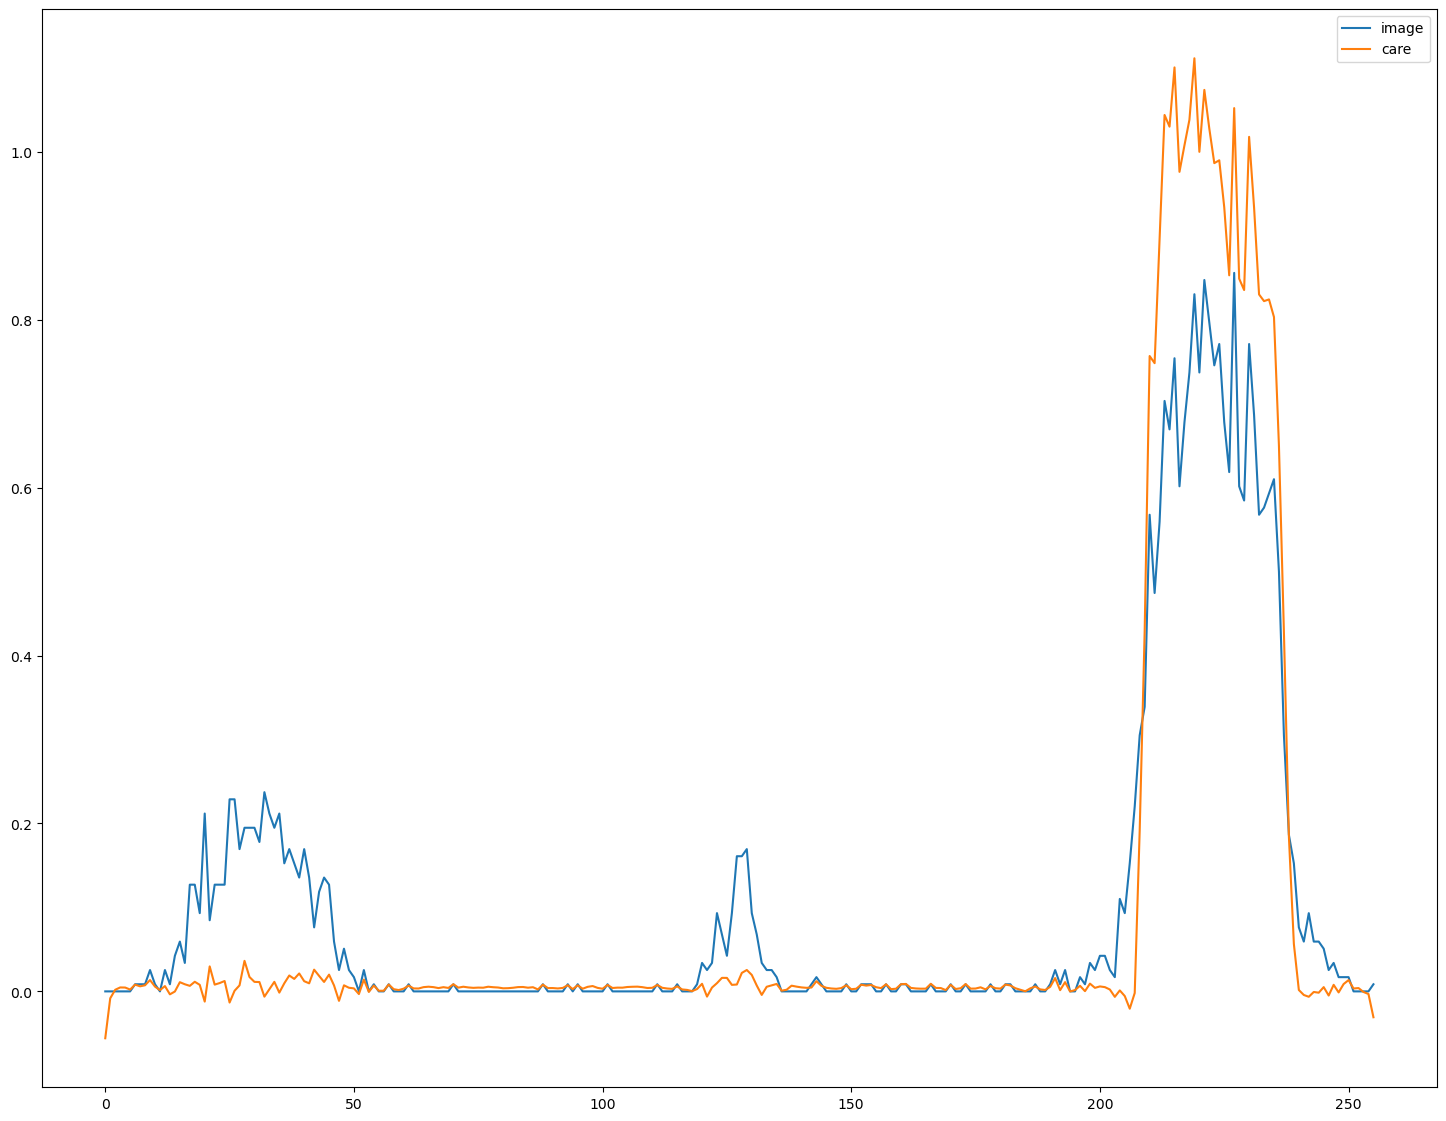

In [39]:
import matplotlib.pyplot as plt

nmax=minmaxes[n]['max']
nmin=minmaxes[n]['min']

phantom = imread('../../data/deep learning testing/ground truth/spheres4.tif')
im = inputs[n]#*(nmax-nmin)+nmin
decon = (restorations[n])#*(nmax-nmin)#*inputs[n].sum()/restorations[n].sum()

s=im.shape

fig, ax = plt.subplots(figsize=(18,14))

line_z=int(s[0]//2)
line_y=int(7*s[1]//8)

line=im[line_z,line_y,:]
ax.plot(line, label = 'image')

line=decon[line_z,line_y,:]
ax.plot(line, label='care')

#line=phantom[line_z,line_y,:]
#ax.plot(line, label='truth')

ax.legend()